# 1. Import der benötigten Packete und des Datenbezugs

In [1]:
import FINE as fn

import pandas as pd
import numpy as np


## Pakete zur Visualisierung

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
## Import Funktion getData

In [4]:
from getData_H1_2021_NP import get_data

In [5]:
data, profile = get_data()

      Connection Car to Wallbox 
0                              1
1                              1
2                              1
3                              1
4                              1
...                          ...
8755                           1
8756                           1
8757                           1
8758                           1
8759                           1

[8760 rows x 1 columns]


# 2. Erstellen der Energy Model Instanzen

In [6]:
# H1 = Haushalt
# electricity = Strom
# ev_electricity = Strom der in das E-Atuo gespeißt wird oder aus der Fahrzeugbatterie bei V2G entnommen wird
# pv_electricity = Strom der von der Solaranlage erzeugt wird
# SG = Saubere Geschirr
# SW = Schmutzige Wäsche
# SWN = Saubere Wäsche Nass
# SWT = Saubere Wäsche Trocken

In [7]:
esM = fn.EnergySystemModel(
    locations={"H1"},
    commodities={"electricity", "ev_electricity0", "geschirr", "nasse_waesche", "trockene_waesche", "schmutzige_waesche", "waesche_fuer_trockner"}, #"heat", "SG", "SWN", "SWT"},
    commodityUnitsDict={"electricity": r"KW$_{el}$", 
                        "ev_electricity0": r"KW$_{el}$", 
                        "geschirr": r"SG",
                        "schmutzige_waesche": r"SW",
                        "nasse_waesche": r"SWN",
                        "waesche_fuer_trockner": r"WFT",
                        "trockene_waesche":r"SWT"},
    numberOfTimeSteps=8760,
    hoursPerTimeStep=1,
    costUnit="1 Euro",
    lengthUnit="m",
    verboseLogLevel=0,
)

# 3. Quellen

## Strombezug

In [8]:
# positive Preise -> Strombezugskosten

esM.add(
    fn.Source(
        esM = esM,
        name = "Import_positive",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax = data["positive_rate_max_import"]["H1"],
        commodityCostTimeSeries = data["positive_prices_import"]["H1"]
    )
)

# negative Preise -> Erträge aus Strombezug

esM.add(
    fn.Source(
        esM = esM,
        name = "Import_negative",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax = data["negative_rate_max_import"]["H1"],
        commodityRevenueTimeSeries = data["negative_prices_import"]["H1"]
    )
)

## Verfügbarkeit Ladungen schmutzige Wäsche 

In [9]:
esM.add(
     fn.Source(
        esM = esM,
        name = "Verfuegbarkeit Waschmaschienenladungen",
        commodity="schmutzige_waesche",
        operationRateMax=pd.DataFrame({"H1": (1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1)*365}),
         hasCapacityVariable=False
    )
)

# Conversion

## Waschmaschine 

In [10]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Waschmaschine",
        physicalUnit= r"SWN",
        commodityConversionFactors={"schmutzige_waesche":-1,"electricity": -0.53, "nasse_waesche": 1},
        hasCapacityVariable=False,
        operationRateMax=pd.DataFrame({"H1": (1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1)*365}),
    )
)    

## Trockner

In [11]:
#Ohne Vorbereitungsconversion
esM.add(
    fn.Conversion(
        esM=esM,
        name="Trockner",
        physicalUnit= r"SWT",
        commodityConversionFactors={"electricity": -1.72, "nasse_waesche": -1, "trockene_waesche": 1},
        hasCapacityVariable=False,
        operationRateMax=pd.DataFrame({"H1": (1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1)*365})
    )
)    

## Speicher

In [12]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Nasse Waesche Storage",
        commodity="nasse_waesche",
        chargeEfficiency=1,
        dischargeEfficiency=1,
        chargeRate=1,
        dischargeRate=1,
        capacityMax=1,
    )
) 

In [13]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Saubere Waesche Storage",
        commodity="trockene_waesche",
        chargeEfficiency=1,
        dischargeEfficiency=1,
        chargeRate=1,
        dischargeRate=1,
        capacityMax=1,
    )
) 

## Demand Saubere Wäsche Trocken 

In [14]:
esM.add(
    fn.Sink(
        esM=esM,
        name="SWT_Demand",
        commodity="trockene_waesche",
        hasCapacityVariable=False,
        operationRateFix=data["H1_Waesche"] ["Demand"] #Für Variablen Einsatz
    )
)

# 5. Optimization

In [15]:
# esM.aggregateTemporally(numberOfTypicalPeriods=7)


In [16]:
esM.optimize(timeSeriesAggregation=False, solver="gurobi")

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.7499 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.6582 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.8572 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(1.2006 sec)

		(0.0000 sec)

Declaring objective function...
		(12.8567 sec)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-21
Read LP format model from file C:\Users\fl5004\AppData\Local\Temp\tmp1rgi6xbf.pyomo.lp
Reading time = 0.18 seconds
x1: 140176 rows, 105138 columns, 341672 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to valu

C:\Users\fl5004\miniforge3\envs\fine\lib\site-packages\FINE\storage.py:1969: UserWarning: Charge and discharge at the same time for component Nasse Waesche Storage
  warnings.warn(
C:\Users\fl5004\miniforge3\envs\fine\lib\site-packages\FINE\storage.py:1969: UserWarning: Charge and discharge at the same time for component Saubere Waesche Storage
  warnings.warn(


for StorageModel ...  (2.5319sec)
		(11.1410 sec)



# 6. Results

In [17]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

H1
Component                              Property        Unit                       
Import_positive                        NPVcontribution [1 Euro]         184.778116
                                       TAC             [1 Euro/a]       184.778116
                                       capacity        [KW$_{el}$]            2.25
                                       commissioning   [KW$_{el}$]            2.25
                                       commodCosts     [1 Euro/a]       184.778116
                                       operation       [KW$_{el}$*h/a]       670.5
                                                       [KW$_{el}$*h]         670.5
SWT_Demand                             operation       [SWT*h/a]             298.0
                                                       [SWT*h]               298.0
Verfuegbarkeit Waschmaschienenladungen operation       [SW*h/a]              298.0
                                                       [SW*h]                298.0

In [18]:
fn.standardIO.writeOptimizationOutputToExcel(esM, outputFileName = "H1 Waschmaschine & Trockner Dynamisch 2021") 


Writing output to Excel... 
	Processing SourceSinkModel ...
	Processing ConversionModel ...
	Processing StorageModel ...
	Saving file...
Done. (6.9101 sec)


In [19]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

H1
Component     Property  Unit            
Trockner      operation [SWT*h/a]  298.0
                        [SWT*h]    298.0
Waschmaschine operation [SWN*h/a]  298.0
                        [SWN*h]    298.0

## Visualising the individual components

In [20]:
fig, ax = fn.plotOperationColorMap(esM, "Waschmaschine", "H1")

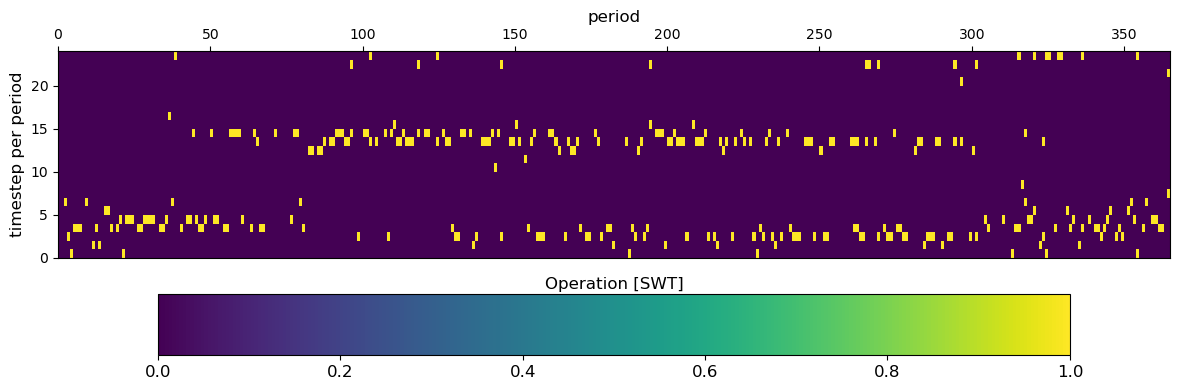

In [21]:
fig, ax = fn.plotOperationColorMap(esM, "Trockner", "H1")